# Import needed modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from PIL import Image


In [ ]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get Data

In [ ]:
import zipfile
import os

zip_path = "data.zip"
extract_path = "dataset"  # مسار استخراج الملفات

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("استخراج البيانات تم بنجاح!")


استخراج البيانات تم بنجاح!


In [ ]:
os.listdir(extract_path)

['Training', 'Testing']

In [ ]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




train_dataset = ImageFolder('/content/dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)



val_dataset = ImageFolder('/content/dataset/Testing', transform=data_transforms)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


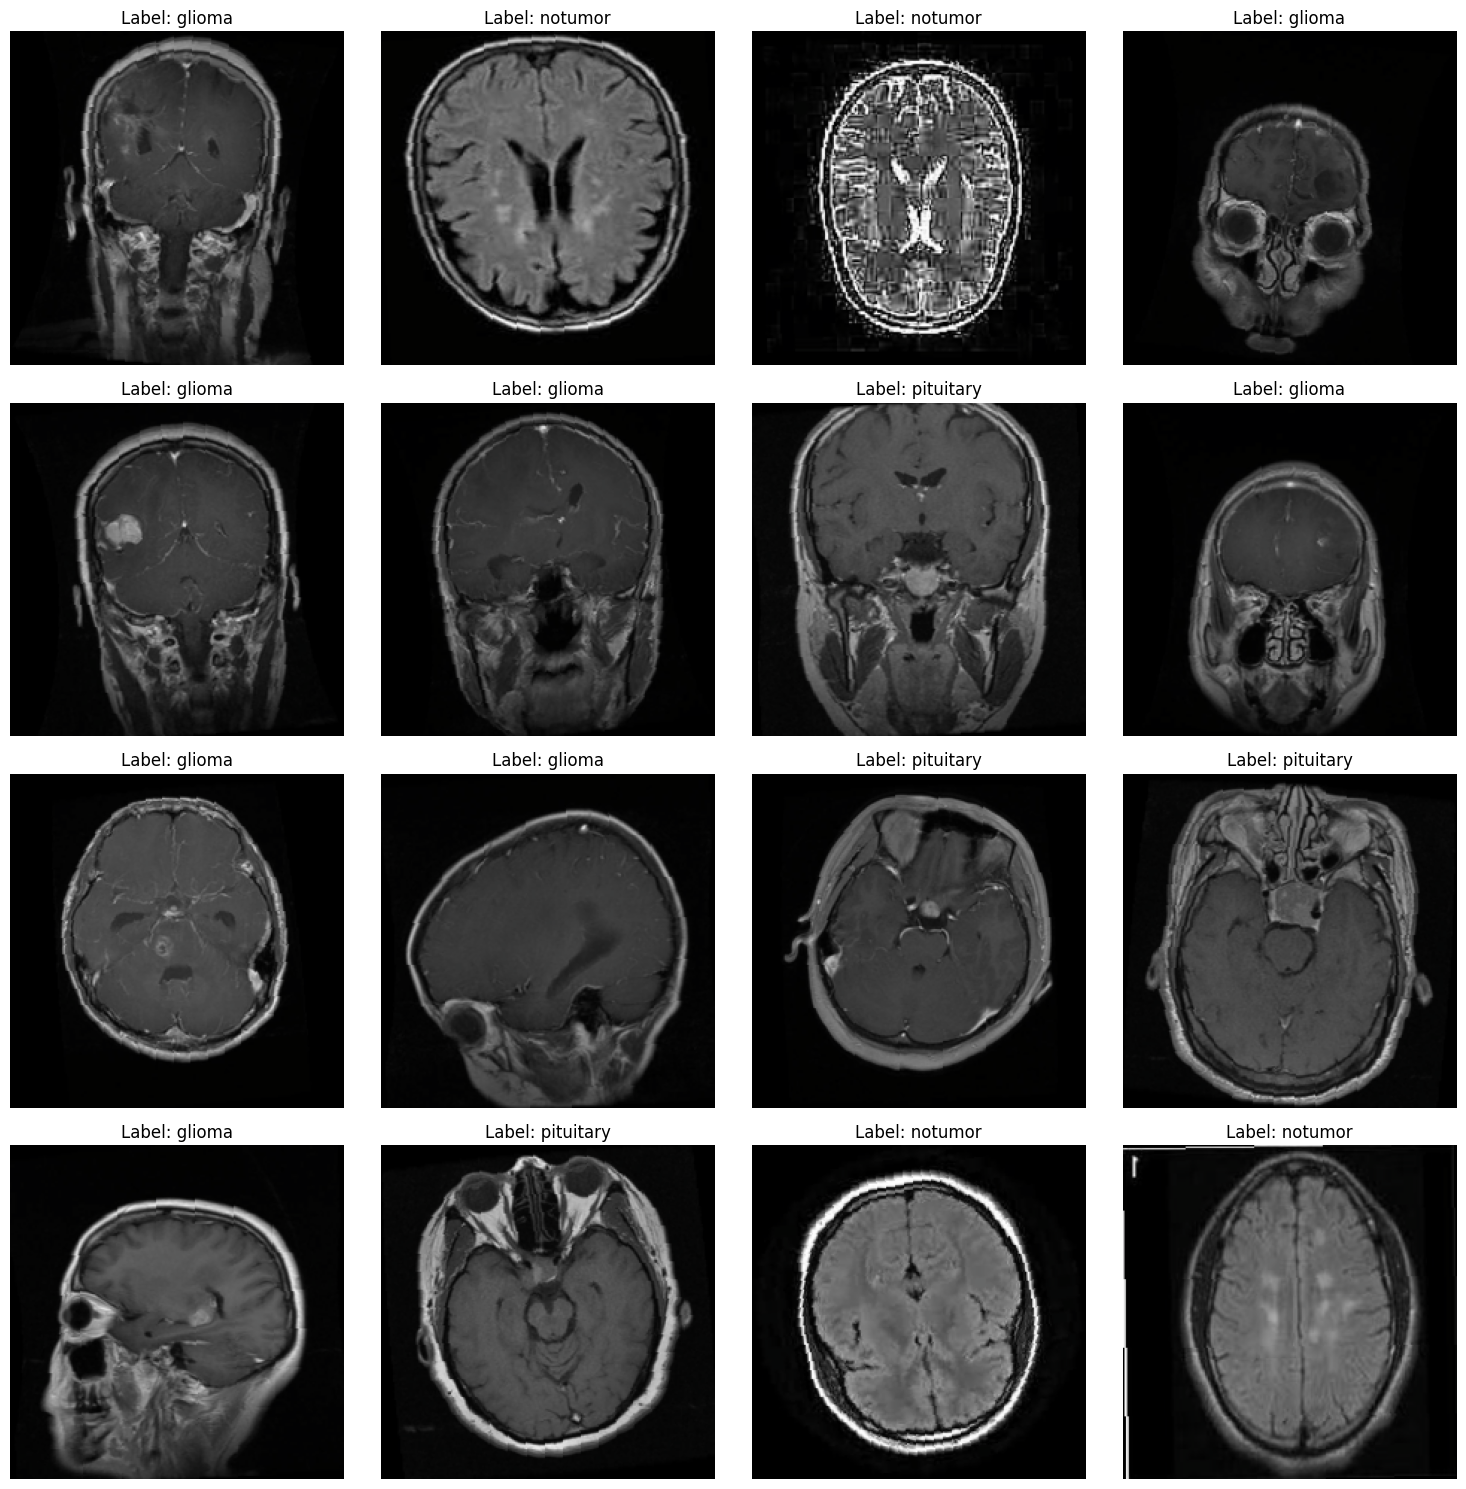

In [ ]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [ ]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential( #fully connected,flatten,
            nn.Linear(32 * 56 * 56, 128),#applies weights & bias after flatten
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = TumorClassifier(num_classes=4)
# Load a pre-trained ResNet model and modify the classifier
model.to(device)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [ ]:
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Training loop
num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


Epoch [1/10], Training Loss: 284.6975, Training Accuracy: 75.63%, Validation Loss: 0.4457, Validation Accuracy: 83.30%
Epoch [2/10], Training Loss: 118.0287, Training Accuracy: 87.68%, Validation Loss: 0.3402, Validation Accuracy: 85.51%
Epoch [3/10], Training Loss: 84.2171, Training Accuracy: 90.98%, Validation Loss: 0.2335, Validation Accuracy: 91.84%
Epoch [4/10], Training Loss: 58.7454, Training Accuracy: 94.22%, Validation Loss: 0.2104, Validation Accuracy: 92.91%
Epoch [5/10], Training Loss: 45.0555, Training Accuracy: 95.62%, Validation Loss: 0.1429, Validation Accuracy: 94.89%
Epoch [6/10], Training Loss: 34.2312, Training Accuracy: 96.78%, Validation Loss: 0.1510, Validation Accuracy: 94.81%
Epoch [7/10], Training Loss: 28.5697, Training Accuracy: 97.27%, Validation Loss: 0.1518, Validation Accuracy: 94.81%
Epoch [8/10], Training Loss: 28.9944, Training Accuracy: 97.29%, Validation Loss: 0.1364, Validation Accuracy: 95.88%
Epoch [9/10], Training Loss: 22.2238, Training Accurac

# Model Evaluation

In [ ]:
accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

Validation Accuracy: 94.58%


# Model visualiztion

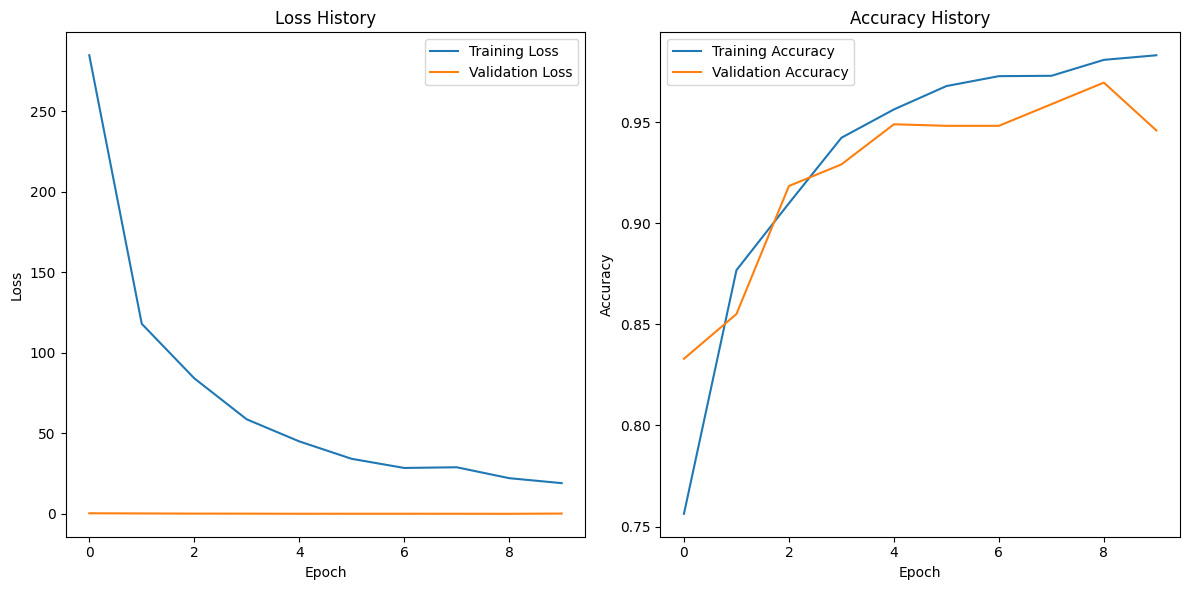

In [ ]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

# Saving Model

In [ ]:
torch.save(model.state_dict(), 'best_model_weights.pth')
print('Model Saved Sucssfully !')

NameError: name 'model' is not defined

# Try Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TumorClassifier(num_classes=4)
model.load_state_dict(torch.load('best_model_weights.pth'))
model.to(device)
model.eval()

class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


<ipython-input-58-a9d8892a1ca7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_weights.pth'))


# Upload Photo

The predicted class is: No Tumor


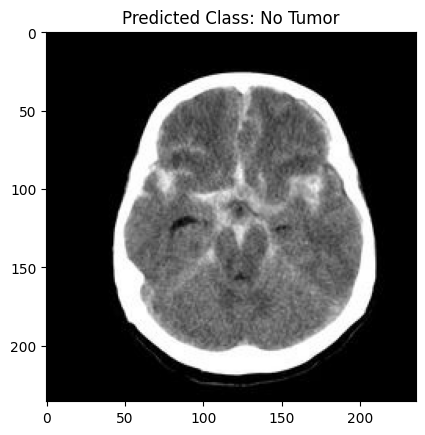

In [ ]:
image_path = '/content/dataset/Testing/notumor/Te-no_0011.jpg'
image = Image.open(image_path)

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

input_batch = input_batch.to(device)

with torch.no_grad():
    outputs = model(input_batch)
    _, predicted = torch.max(outputs, 1)

predicted_class = class_names[predicted.item()]
print(f'The predicted class is: {predicted_class}')

plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.show()

The predicted class is: Meningioma


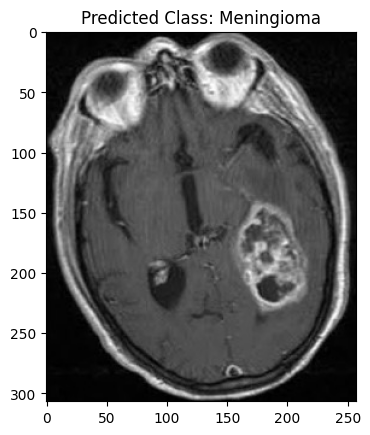

In [ ]:
image_path = '/content/dataset/Testing/meningioma/Te-meTr_0001.jpg'
image = Image.open(image_path)

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

input_batch = input_batch.to(device)

with torch.no_grad():
    outputs = model(input_batch)
    _, predicted = torch.max(outputs, 1)

predicted_class = class_names[predicted.item()]
print(f'The predicted class is: {predicted_class}')

plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.show()

The predicted class is: Glioma


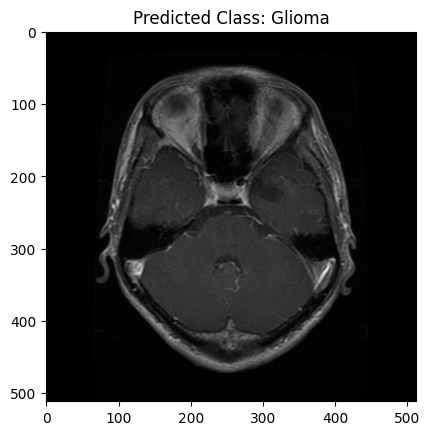

In [ ]:
image_path = '/content/dataset/Testing/glioma/Te-glTr_0001.jpg'
image = Image.open(image_path)

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

input_batch = input_batch.to(device)

with torch.no_grad():
    outputs = model(input_batch)
    _, predicted = torch.max(outputs, 1)

predicted_class = class_names[predicted.item()]
print(f'The predicted class is: {predicted_class}')

plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.show()

The predicted class is: Pituitary


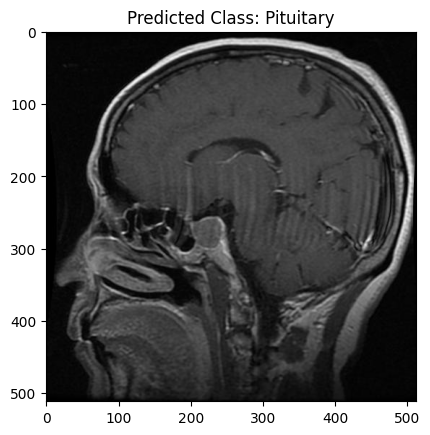

In [ ]:
image_path = '/content/dataset/Testing/pituitary/Te-piTr_0007.jpg'
image = Image.open(image_path)

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

input_batch = input_batch.to(device)

with torch.no_grad():
    outputs = model(input_batch)
    _, predicted = torch.max(outputs, 1)

predicted_class = class_names[predicted.item()]
print(f'The predicted class is: {predicted_class}')

plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.show()